In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "2"

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer # for building a preprocessing pipeline
from sklearn.pipeline import Pipeline # for building a preprocessing pipeline
from sklearn.decomposition import PCA # for dimensionality reduction
from sklearn.cluster import KMeans # for clustering & evaluation
from sklearn.metrics import silhouette_score # for clustering & evaluation
from scipy.stats import skew # for checking distribution skewness

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Importing Data
# ==============================

In [4]:
# reading excel files

dim_users = pd.read_excel('dim_users.xlsx')
dim_user_contacts = pd.read_excel('dim_user_contacts.xlsx')
fct_ledger_entries = pd.read_excel('fct_ledger_entries.xlsx')
fct_payment_transactions = pd.read_excel('fct_payment_transactions.xlsx')
int_events = pd.read_excel('int_events.xlsx')


In [5]:
dim_users.head()

,user_id,signup_date,onboarded_with_referral,applied_for_loan
0,1,2025-05-06,False,False
1,2,2024-12-16,False,False
2,3,2025-03-27,False,False
3,4,2025-01-15,True,False
4,5,2023-06-13,False,False


In [6]:
dim_user_contacts.head()

,user_id,contact_id,contract_created_time
0,1,C00001,2025-05-21 16:24:00
1,1,C00002,2025-05-16 05:29:00
2,2,C00003,2025-05-04 11:43:00
3,2,C00004,2025-02-21 19:30:00
4,3,C00005,2025-04-11 08:35:00


In [7]:
fct_ledger_entries.head()

,entry_id,entry_time,user_id,entry_amount,entry_type,entry_comments
0,L000001,2025-05-24 13:09:00,1,153.46,receivable,Subscription fee
1,L000002,2025-05-07 03:15:00,1,100.02,receivable,Credit adjustment
2,L000003,2025-05-11 20:47:00,1,95.09,payable,Funds transfer
3,L000004,2025-05-18 08:40:00,1,159.54,receivable,Initial deposit
4,L000005,2025-05-09 03:05:00,1,36.32,payable,Initial deposit


In [8]:
fct_payment_transactions.head()

,transaction_id,transaction_time,user_id,transaction_amount
0,T000001,2025-05-18 10:47:00,1,147.79
1,T000002,2025-05-15 20:55:00,1,157.13
2,T000003,2025-05-17 21:20:00,1,101.48
3,T000004,2025-05-16 21:39:00,1,258.63
4,T000005,2025-05-15 23:32:00,1,99.78


In [9]:
int_events.head()

,event_id,entry_timestamp,user_id,app_feature,event_name
0,E0000001,2025-05-06 17:16:15,1,Savings,Viewed_Screen
1,E0000002,2025-05-24 14:41:46,1,Savings,Viewed_Screen
2,E0000003,2025-05-09 17:19:38,1,Savings,Session_Start
3,E0000004,2025-05-18 22:21:38,1,Savings,Viewed_Screen
4,E0000005,2025-05-25 17:37:26,1,Savings,Session_End


# ==============================
# Feature Engineering
# ==============================

In [10]:
# 1. base user features from dim_users

user_features = (
    dim_users
    .assign(
        days_since_signup=(pd.to_datetime(datetime.today())  - dim_users['signup_date']).dt.days,
        onboarded_with_referral=dim_users['onboarded_with_referral'], # lambda df: np.where(df['onboarded_with_referral'], 1, 0),
        applied_for_loan=dim_users['applied_for_loan'] # lambda df: np.where(df['applied_for_loan'], 1, 0)
    )
    [['user_id', 'days_since_signup', 'onboarded_with_referral', 'applied_for_loan']]
)

user_features

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan
0,1,32,False,False
1,2,173,False,False
2,3,72,False,False
3,4,143,True,False
4,5,725,False,False
...,...,...,...,...
495,496,225,False,False
496,497,110,True,False
497,498,90,False,False
498,499,706,False,False


In [11]:
# 2. features from dim_user_contacts

contacts_agg = (
    dim_user_contacts
    .merge(dim_users[['user_id', 'signup_date']], on='user_id', how='left') # Merge signup_date here
    .groupby(['user_id', 'signup_date'])
    .agg(
        num_contacts=('contact_id', 'nunique'),
        first_contact_time=('contract_created_time', 'min') # Keep this to calculate diff
    )
    .reset_index()
    .assign(
        days_to_first_contact=lambda df: (pd.to_datetime(df['first_contact_time']) - pd.to_datetime(df['signup_date'])).dt.days # Calculate days_to_first_contact
    )
    .drop(columns=['first_contact_time', 'signup_date']) # Drop intermediate date columns
)

contacts_agg

,user_id,num_contacts,days_to_first_contact
0,1,2,10
1,2,2,67
2,3,1,15
3,4,2,57
4,5,7,43
...,...,...,...
454,495,2,289
455,496,3,24
456,498,2,58
457,499,7,9


In [12]:
# 3. features from fct_ledger_entries

# preparing temporary columns for conditional aggregations
ledger_temp = (
    fct_ledger_entries
    .merge(dim_users[['user_id', 'signup_date']], on='user_id', how='left')
    .assign(
        is_payable_entry=lambda df: np.where(df['entry_type'] == 'payable', 1, 0),
        is_receivable_entry=lambda df: np.where(df['entry_type'] == 'receivable', 1, 0),
        receivable_amount_val=lambda df: np.where(df['entry_type'] == 'receivable', df['entry_amount'], 0),
        payable_amount_val=lambda df: np.where(df['entry_type'] == 'payable', df['entry_amount'], 0)
    )
)

ledger_agg = (
    ledger_temp
    .groupby(['user_id', 'signup_date'])
    .agg(
        total_ledger_amount=('entry_amount', 'sum'),
        avg_ledger_entry_amount=('entry_amount', 'mean'),
        num_ledger_entries=('entry_id', 'nunique'),
        num_payable_entries=('is_payable_entry', 'sum'),
        num_receivable_entries=('is_receivable_entry', 'sum'),
        receivable_sum=('receivable_amount_val', 'sum'), # Get sum of receivables (used to calculate net ledger balance later)
        payable_sum=('payable_amount_val', 'sum'),       # Get sum of payables (used to calculate net ledger balance later)
        first_entry_time=('entry_time', 'min')
    )
    .reset_index()
    .assign(
        days_to_first_entry=lambda df: (pd.to_datetime(df['first_entry_time']) - pd.to_datetime(df['signup_date'])).dt.days, # Calculate days_to_first_contact
        net_ledger_balance=lambda df: df['receivable_sum'] - df['payable_sum'] # Calculate net balance
    )
    .drop(columns=['signup_date', 'first_entry_time', 'receivable_sum', 'payable_sum']) # Drop intermediate columns
)

# calculating ledger entry frequency
ledger_freq = (
    fct_ledger_entries
    .sort_values(['user_id', 'entry_time'])
    .groupby('user_id')
    .apply(lambda x: pd.to_datetime(x['entry_time']).diff().dropna().dt.total_seconds().mean() / (24*3600) if len(x) > 1 else np.nan) # mean diff in days
    .reset_index(name='ledger_entry_frequency_days')
)

ledger_agg

,user_id,total_ledger_amount,avg_ledger_entry_amount,num_ledger_entries,num_payable_entries,num_receivable_entries,days_to_first_entry,net_ledger_balance
0,1,1727.64,115.176000,15,8,7,0,101.90
1,2,2447.92,128.837895,19,9,10,9,348.76
2,3,3302.73,122.323333,27,15,12,0,-703.29
3,4,1403.02,93.534667,15,8,7,13,-116.48
4,5,13349.95,360.809459,37,20,17,21,-697.27
...,...,...,...,...,...,...,...,...
495,496,24598.51,307.481375,80,40,40,3,-909.85
496,497,3318.79,132.751600,25,11,14,0,258.75
497,498,1103.50,110.350000,10,4,6,15,7.52
498,499,9373.32,302.365161,31,13,18,3,2311.32


In [13]:
# 4. features from fct_payment_transactions

transactions_agg = (
    fct_payment_transactions
    .merge(dim_users[['user_id', 'signup_date']], on='user_id', how='left')
    .groupby(['user_id', 'signup_date'])
    .agg(
        total_transaction_amount=('transaction_amount', 'sum'),
        avg_transaction_amount=('transaction_amount', 'mean'),
        num_transactions=('transaction_id', 'nunique'),
        first_transaction_time=('transaction_time', 'min')
    )
    .reset_index()
    .assign(
        days_to_first_transaction=lambda df: (pd.to_datetime(df['first_transaction_time']) - pd.to_datetime(df['signup_date'])).dt.days # Calculate days_to_first_contact
    )
    .drop(columns=['signup_date', 'first_transaction_time']) # dropping intermediate columns
)

# calculating transaction frequency
transaction_freq = (
    fct_payment_transactions
    .sort_values(['user_id', 'transaction_time'])
    .groupby('user_id')
    .apply(lambda x: pd.to_datetime(x['transaction_time']).diff().dropna().dt.total_seconds().mean() / (24*3600) if len(x) > 1 else np.nan) # mean diff in days
    .reset_index(name='transaction_frequency_days')
)

transactions_agg

,user_id,total_transaction_amount,avg_transaction_amount,num_transactions,days_to_first_transaction
0,1,2312.53,192.710833,12,0
1,2,1362.00,227.000000,6,20
2,3,1183.96,197.326667,6,0
3,4,2848.69,189.912667,15,0
4,5,47440.42,677.720286,70,2
...,...,...,...,...,...
495,496,13706.00,721.368421,19,3
496,497,703.31,175.827500,4,29
497,498,3039.52,202.634667,15,4
498,499,40928.35,670.956557,61,11


In [14]:
# 5. Features from int_events - App Breadth Score

# calculate app breadth score (avg number of distinct features users interacts with in 1 week)
app_breadth_score_df = (
    int_events
    .assign(
        event_week=lambda df: pd.to_datetime(df['entry_timestamp']).dt.to_period('W')
    )
    .groupby(['user_id', 'event_week'])
    .agg(
        distinct_features_in_week=('app_feature', 'nunique')
    )
    .reset_index()
    .groupby('user_id')
    .agg(
        app_breadth_score=('distinct_features_in_week', 'median')
    )
    .reset_index()
)

app_breadth_score_df

,user_id,app_breadth_score
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.5
...,...,...
495,496,2.0
496,497,1.5
497,498,1.0
498,499,1.0


In [15]:
# 6. Combine all features into one final table using merges
final_features = (
    user_features
    .merge(contacts_agg, on='user_id', how='left')
    .merge(ledger_agg, on='user_id', how='left')
    .merge(ledger_freq, on='user_id', how='left')
    .merge(transactions_agg, on='user_id', how='left')
    .merge(transaction_freq, on='user_id', how='left')
    .merge(app_breadth_score_df, on='user_id', how='left')
)

final_features

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan,num_contacts,days_to_first_contact,total_ledger_amount,avg_ledger_entry_amount,num_ledger_entries,num_payable_entries,num_receivable_entries,days_to_first_entry,net_ledger_balance,ledger_entry_frequency_days,total_transaction_amount,avg_transaction_amount,num_transactions,days_to_first_transaction,transaction_frequency_days,app_breadth_score
0,1,32,False,False,2.0,10.0,1727.64,115.176000,15,8,7,0,101.90,1.319296,2312.53,192.710833,12,0,1.220518,1.0
1,2,173,False,False,2.0,67.0,2447.92,128.837895,19,9,10,9,348.76,8.349344,1362.00,227.000000,6,20,22.899583,1.0
2,3,72,False,False,1.0,15.0,3302.73,122.323333,27,15,12,0,-703.29,2.234054,1183.96,197.326667,6,0,10.970972,1.0
3,4,143,True,False,2.0,57.0,1403.02,93.534667,15,8,7,13,-116.48,8.179712,2848.69,189.912667,15,0,9.108135,1.0
4,5,725,False,False,7.0,43.0,13349.95,360.809459,37,20,17,21,-697.27,18.121451,47440.42,677.720286,70,2,10.172907,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,225,False,False,3.0,24.0,24598.51,307.481375,80,40,40,3,-909.85,2.608351,13706.00,721.368421,19,3,10.964699,2.0
496,497,110,True,False,NaN,NaN,3318.79,132.751600,25,11,14,0,258.75,3.979861,703.31,175.827500,4,29,10.588426,1.5
497,498,90,False,False,2.0,58.0,1103.50,110.350000,10,4,6,15,7.52,6.619830,3039.52,202.634667,15,4,5.139385,1.0
498,499,706,False,False,7.0,9.0,9373.32,302.365161,31,13,18,3,2311.32,21.757431,40928.35,670.956557,61,11,11.316898,1.0


In [16]:
# replacing NULLs with 0 (for users with no contacts/entries/transactions)
# replacing with 0 for other counts/sums 
# replacing with a large value (e.g., days_since_signup + 1) for days_to_first_transaction/entry/contact
# filling NULL transaction/entry frequencies with days_since_signup (implies very low freq) for users who have 0 or 1 entry/transaction

final_features = (
    final_features
    .fillna({
        'num_contacts': 0,
        'days_to_first_contact': final_features['days_since_signup'] + 1,
        'total_ledger_amount': 0,
        'avg_ledger_entry_amount': 0,
        'num_ledger_entries': 0,
        'num_payable_entries': 0,
        'num_receivable_entries': 0,
        'net_ledger_balance': 0,
        'days_to_first_entry': final_features['days_since_signup'] + 1,
        'ledger_entry_frequency_days': final_features['days_since_signup'],
        'total_transaction_amount': 0,
        'avg_transaction_amount': 0,
        'num_transactions': 0,
        'days_to_first_transaction': final_features['days_since_signup'] + 1,
        'transaction_frequency_days': final_features['days_since_signup'], 
        'app_breadth_score': 0
    })
)

final_features_df = (
    final_features[[
        'user_id',
        'days_since_signup',
        'onboarded_with_referral',
        'applied_for_loan',
        'num_contacts',
        'days_to_first_contact',
        'total_ledger_amount',
        'avg_ledger_entry_amount',
        'num_ledger_entries',
        'num_payable_entries',
        'num_receivable_entries',
        'net_ledger_balance',
        'ledger_entry_frequency_days',
        'days_to_first_entry',
        'total_transaction_amount',
        'avg_transaction_amount',
        'num_transactions',
        'transaction_frequency_days',
        'days_to_first_transaction',
        'app_breadth_score'
    ]]
)

final_features_df

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan,num_contacts,days_to_first_contact,total_ledger_amount,avg_ledger_entry_amount,num_ledger_entries,num_payable_entries,num_receivable_entries,net_ledger_balance,ledger_entry_frequency_days,days_to_first_entry,total_transaction_amount,avg_transaction_amount,num_transactions,transaction_frequency_days,days_to_first_transaction,app_breadth_score
0,1,32,False,False,2.0,10.0,1727.64,115.176000,15,8,7,101.90,1.319296,0,2312.53,192.710833,12,1.220518,0,1.0
1,2,173,False,False,2.0,67.0,2447.92,128.837895,19,9,10,348.76,8.349344,9,1362.00,227.000000,6,22.899583,20,1.0
2,3,72,False,False,1.0,15.0,3302.73,122.323333,27,15,12,-703.29,2.234054,0,1183.96,197.326667,6,10.970972,0,1.0
3,4,143,True,False,2.0,57.0,1403.02,93.534667,15,8,7,-116.48,8.179712,13,2848.69,189.912667,15,9.108135,0,1.0
4,5,725,False,False,7.0,43.0,13349.95,360.809459,37,20,17,-697.27,18.121451,21,47440.42,677.720286,70,10.172907,2,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,225,False,False,3.0,24.0,24598.51,307.481375,80,40,40,-909.85,2.608351,3,13706.00,721.368421,19,10.964699,3,2.0
496,497,110,True,False,0.0,111.0,3318.79,132.751600,25,11,14,258.75,3.979861,0,703.31,175.827500,4,10.588426,29,1.5
497,498,90,False,False,2.0,58.0,1103.50,110.350000,10,4,6,7.52,6.619830,15,3039.52,202.634667,15,5.139385,4,1.0
498,499,706,False,False,7.0,9.0,9373.32,302.365161,31,13,18,2311.32,21.757431,3,40928.35,670.956557,61,11.316898,11,1.0


# ==============================
# EDA and Data Preprocessing
# ==============================

In [17]:
# creating a list of continuous_numerical_features

# excluding 'user_id' as it's an identifier, not a feature for clustering directly
final_features_df_eda = final_features_df.drop(columns=['user_id'])
numerical_features = final_features_df_eda.select_dtypes(include=np.number).columns.tolist()
# excluding encoded binary features from continuous numerical features
continuous_numerical_features = [col for col in numerical_features if not col.endswith('_encoded')]

# creating a separate dataframe for storing preprocessed features
# keeping a backup of the old dataframe with original feature values
final_features_df_preprocessed = final_features_df.copy()

### Basic Descriptive Statistics

In [18]:
print("\n1. Descriptive Statistics:")
final_features_df_eda.describe().round(1).T


1. Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
days_since_signup,500.0,486.8,289.3,27.0,249.8,451.0,696.2,1104.0
num_contacts,500.0,6.3,5.4,0.0,2.0,5.0,8.0,20.0
days_to_first_contact,500.0,83.7,88.3,0.0,20.0,55.5,116.0,473.0
total_ledger_amount,500.0,32703.5,37154.7,330.6,3130.6,16074.7,58363.2,133908.8
avg_ledger_entry_amount,500.0,360.6,211.7,66.1,139.2,319.0,618.6,711.2
num_ledger_entries,500.0,64.7,52.2,5.0,24.0,51.0,90.0,199.0
num_payable_entries,500.0,32.4,26.6,1.0,12.0,24.0,45.2,110.0
num_receivable_entries,500.0,32.3,26.2,0.0,11.0,24.0,48.0,111.0
net_ledger_balance,500.0,-306.0,5006.7,-25499.1,-1492.7,-18.8,1032.7,23488.6
ledger_entry_frequency_days,500.0,9.9,8.0,0.7,5.1,8.0,11.9,72.0


### Checking for Missing Values

In [19]:
# we already took care of missing values but doing this as a confirmation)

print('\nColumns with missing values:', final_features_df.isnull().sum().sum())
print("\nMissing Values Check (for each column):")
print(final_features_df.isnull().sum())



Columns with missing values: 0

Missing Values Check (for each column):
user_id                        0
days_since_signup              0
onboarded_with_referral        0
applied_for_loan               0
num_contacts                   0
days_to_first_contact          0
total_ledger_amount            0
avg_ledger_entry_amount        0
num_ledger_entries             0
num_payable_entries            0
num_receivable_entries         0
net_ledger_balance             0
ledger_entry_frequency_days    0
days_to_first_entry            0
total_transaction_amount       0
avg_transaction_amount         0
num_transactions               0
transaction_frequency_days     0
days_to_first_transaction      0
app_breadth_score              0
dtype: int64


### Checking for Outliers (and treating them)

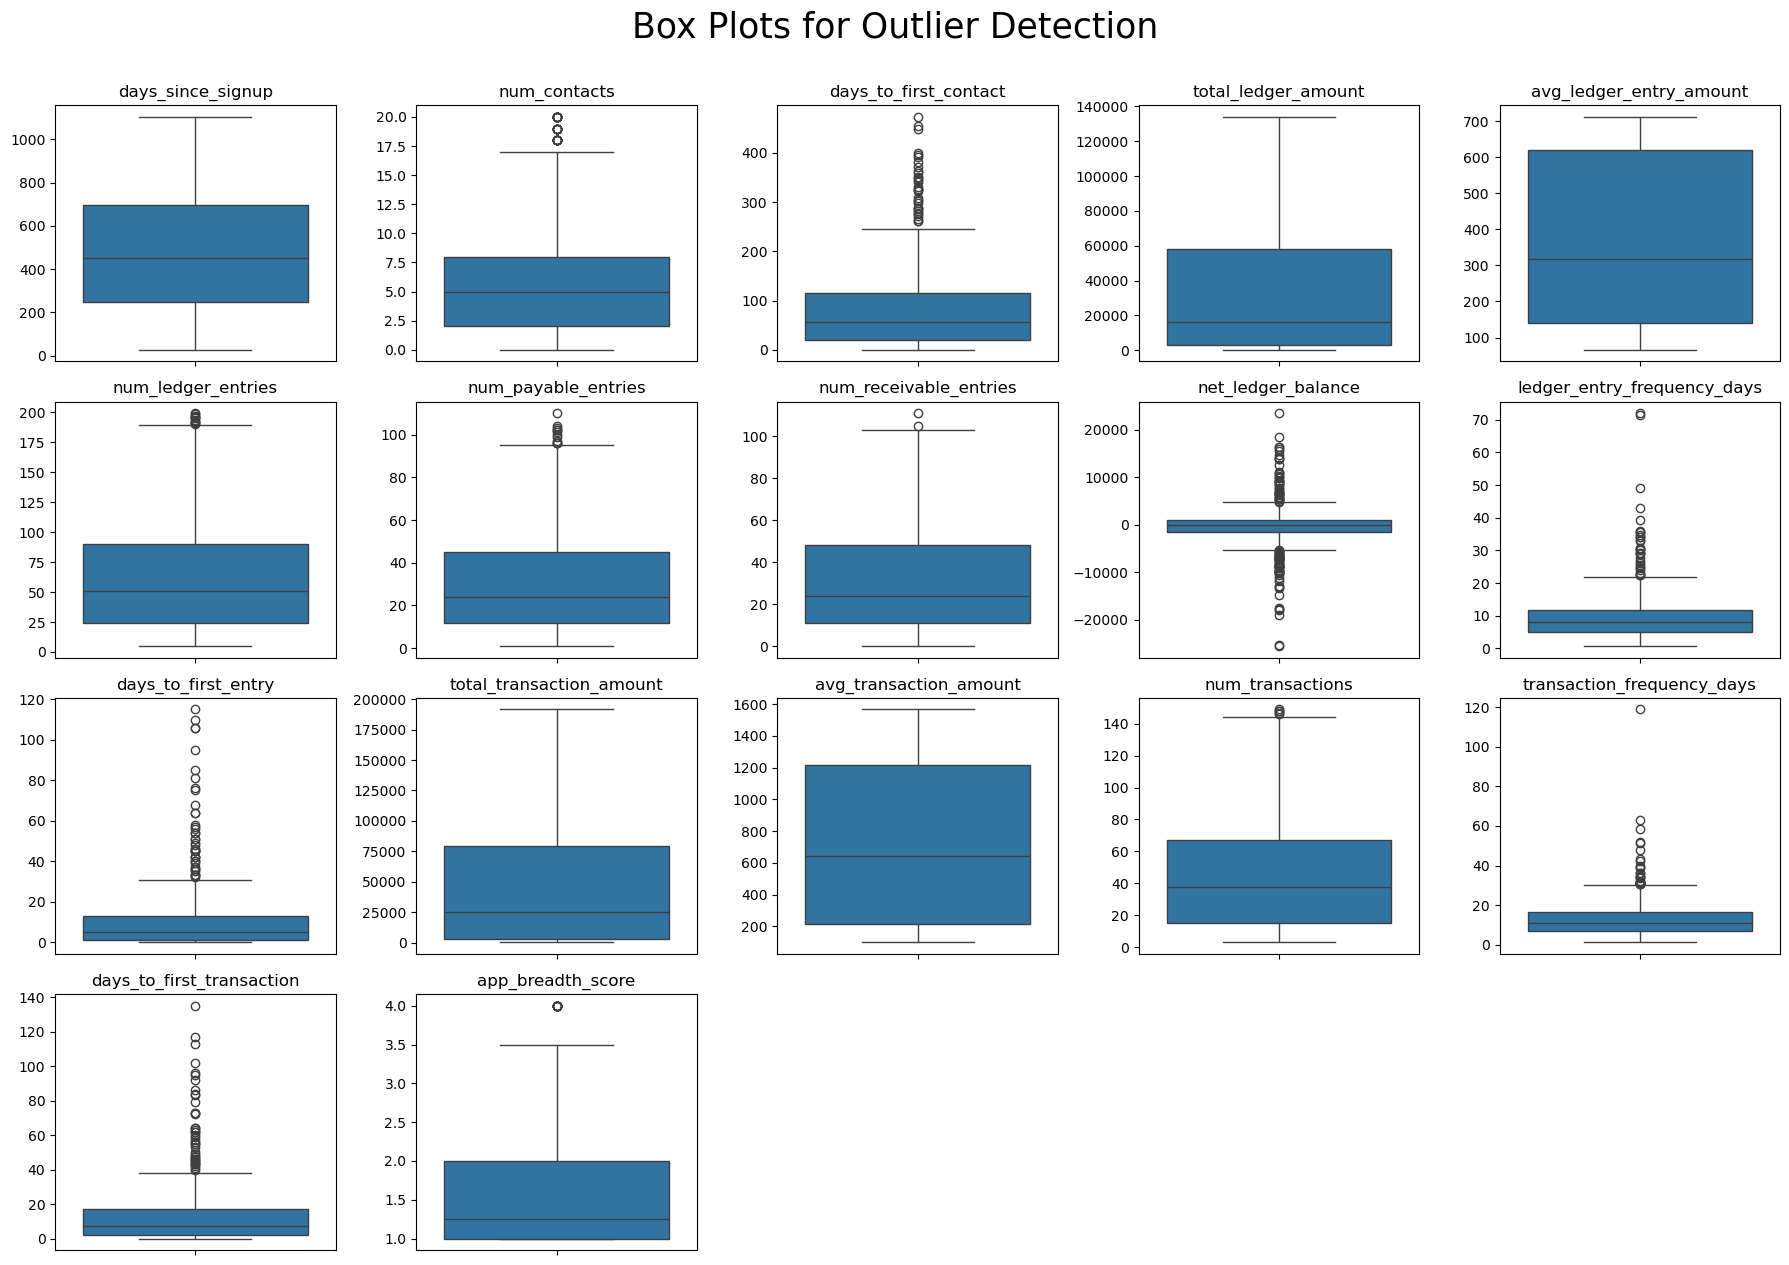

In [20]:
plt.figure(figsize=(18, 12))
for i, feature in enumerate(continuous_numerical_features):
    plt.subplot(4, 5, i + 1)
    sns.boxplot(y=final_features_df_preprocessed[feature])
    plt.title(feature)
    plt.ylabel('')
plt.tight_layout()
plt.suptitle('Box Plots for Outlier Detection', y=1.05, fontsize=25)
plt.show()

# boxplots with individual points beyond the whiskers indicate outliers

In [21]:
# treating features with outliers

features_with_outliers = [
    'num_contacts', 'days_to_first_contact', 'num_ledger_entries', 'num_payable_entries',
    'num_receivable_entries', 'net_ledger_balance', 'ledger_entry_frequency_days',
    'days_to_first_entry', 'num_transactions', 'transaction_frequency_days', 'days_to_first_transaction',
    'app_breadth_score'
]

# clipping the values of outliers to the 1st and 99th percentile values for each feature
for feature in features_with_outliers:
    percentile_1 = final_features_df_preprocessed[feature].quantile(0.01)
    percentile_99 = final_features_df_preprocessed[feature].quantile(0.99)
    # Create a new column with clipped values
    final_features_df_preprocessed[feature] = final_features_df_preprocessed[feature].clip(lower=percentile_1, upper=percentile_99)
    
final_features_df_preprocessed

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan,num_contacts,days_to_first_contact,total_ledger_amount,avg_ledger_entry_amount,num_ledger_entries,num_payable_entries,num_receivable_entries,net_ledger_balance,ledger_entry_frequency_days,days_to_first_entry,total_transaction_amount,avg_transaction_amount,num_transactions,transaction_frequency_days,days_to_first_transaction,app_breadth_score
0,1,32,False,False,2.0,10.0,1727.64,115.176000,15.0,8.0,7.0,101.90,1.610837,0.0,2312.53,192.710833,12.0,2.269069,0.0,1.0
1,2,173,False,False,2.0,67.0,2447.92,128.837895,19.0,9.0,10.0,348.76,8.349344,9.0,1362.00,227.000000,6.0,22.899583,20.0,1.0
2,3,72,False,False,1.0,15.0,3302.73,122.323333,27.0,15.0,12.0,-703.29,2.234054,0.0,1183.96,197.326667,6.0,10.970972,0.0,1.0
3,4,143,True,False,2.0,57.0,1403.02,93.534667,15.0,8.0,7.0,-116.48,8.179712,13.0,2848.69,189.912667,15.0,9.108135,0.0,1.0
4,5,725,False,False,7.0,43.0,13349.95,360.809459,37.0,20.0,17.0,-697.27,18.121451,21.0,47440.42,677.720286,70.0,10.172907,2.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,225,False,False,3.0,24.0,24598.51,307.481375,80.0,40.0,40.0,-909.85,2.608351,3.0,13706.00,721.368421,19.0,10.964699,3.0,2.0
496,497,110,True,False,0.0,111.0,3318.79,132.751600,25.0,11.0,14.0,258.75,3.979861,0.0,703.31,175.827500,4.0,10.588426,29.0,1.5
497,498,90,False,False,2.0,58.0,1103.50,110.350000,10.0,4.0,6.0,7.52,6.619830,15.0,3039.52,202.634667,15.0,5.139385,4.0,1.0
498,499,706,False,False,7.0,9.0,9373.32,302.365161,31.0,13.0,18.0,2311.32,21.757431,3.0,40928.35,670.956557,61.0,11.316898,11.0,1.0


### Checking for Variables with Negative Values (and treating them)

In [22]:
# treating features with negative values

features_with_negative_values = ['net_ledger_balance']

# using the Yeo-Johnson Power Transformer to adjust for negative-value features
pt = PowerTransformer(method='yeo-johnson')
for feature in features_with_negative_values:
    # Create a new column with negative-adjusted values
    final_features_df_preprocessed[feature] = pt.fit_transform(final_features_df_preprocessed[['net_ledger_balance']])
    
final_features_df_preprocessed

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan,num_contacts,days_to_first_contact,total_ledger_amount,avg_ledger_entry_amount,num_ledger_entries,num_payable_entries,num_receivable_entries,net_ledger_balance,ledger_entry_frequency_days,days_to_first_entry,total_transaction_amount,avg_transaction_amount,num_transactions,transaction_frequency_days,days_to_first_transaction,app_breadth_score
0,1,32,False,False,2.0,10.0,1727.64,115.176000,15.0,8.0,7.0,0.066278,1.610837,0.0,2312.53,192.710833,12.0,2.269069,0.0,1.0
1,2,173,False,False,2.0,67.0,2447.92,128.837895,19.0,9.0,10.0,0.119425,8.349344,9.0,1362.00,227.000000,6.0,22.899583,20.0,1.0
2,3,72,False,False,1.0,15.0,3302.73,122.323333,27.0,15.0,12.0,-0.100826,2.234054,0.0,1183.96,197.326667,6.0,10.970972,0.0,1.0
3,4,143,True,False,2.0,57.0,1403.02,93.534667,15.0,8.0,7.0,0.020253,8.179712,13.0,2848.69,189.912667,15.0,9.108135,0.0,1.0
4,5,725,False,False,7.0,43.0,13349.95,360.809459,37.0,20.0,17.0,-0.099587,18.121451,21.0,47440.42,677.720286,70.0,10.172907,2.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,225,False,False,3.0,24.0,24598.51,307.481375,80.0,40.0,40.0,-0.143322,2.608351,3.0,13706.00,721.368421,19.0,10.964699,3.0,2.0
496,497,110,True,False,0.0,111.0,3318.79,132.751600,25.0,11.0,14.0,0.100021,3.979861,0.0,703.31,175.827500,4.0,10.588426,29.0,1.5
497,498,90,False,False,2.0,58.0,1103.50,110.350000,10.0,4.0,6.0,0.046073,6.619830,15.0,3039.52,202.634667,15.0,5.139385,4.0,1.0
498,499,706,False,False,7.0,9.0,9373.32,302.365161,31.0,13.0,18.0,0.544696,21.757431,3.0,40928.35,670.956557,61.0,11.316898,11.0,1.0


### Checking for Skewness in Distributions (and treating them)

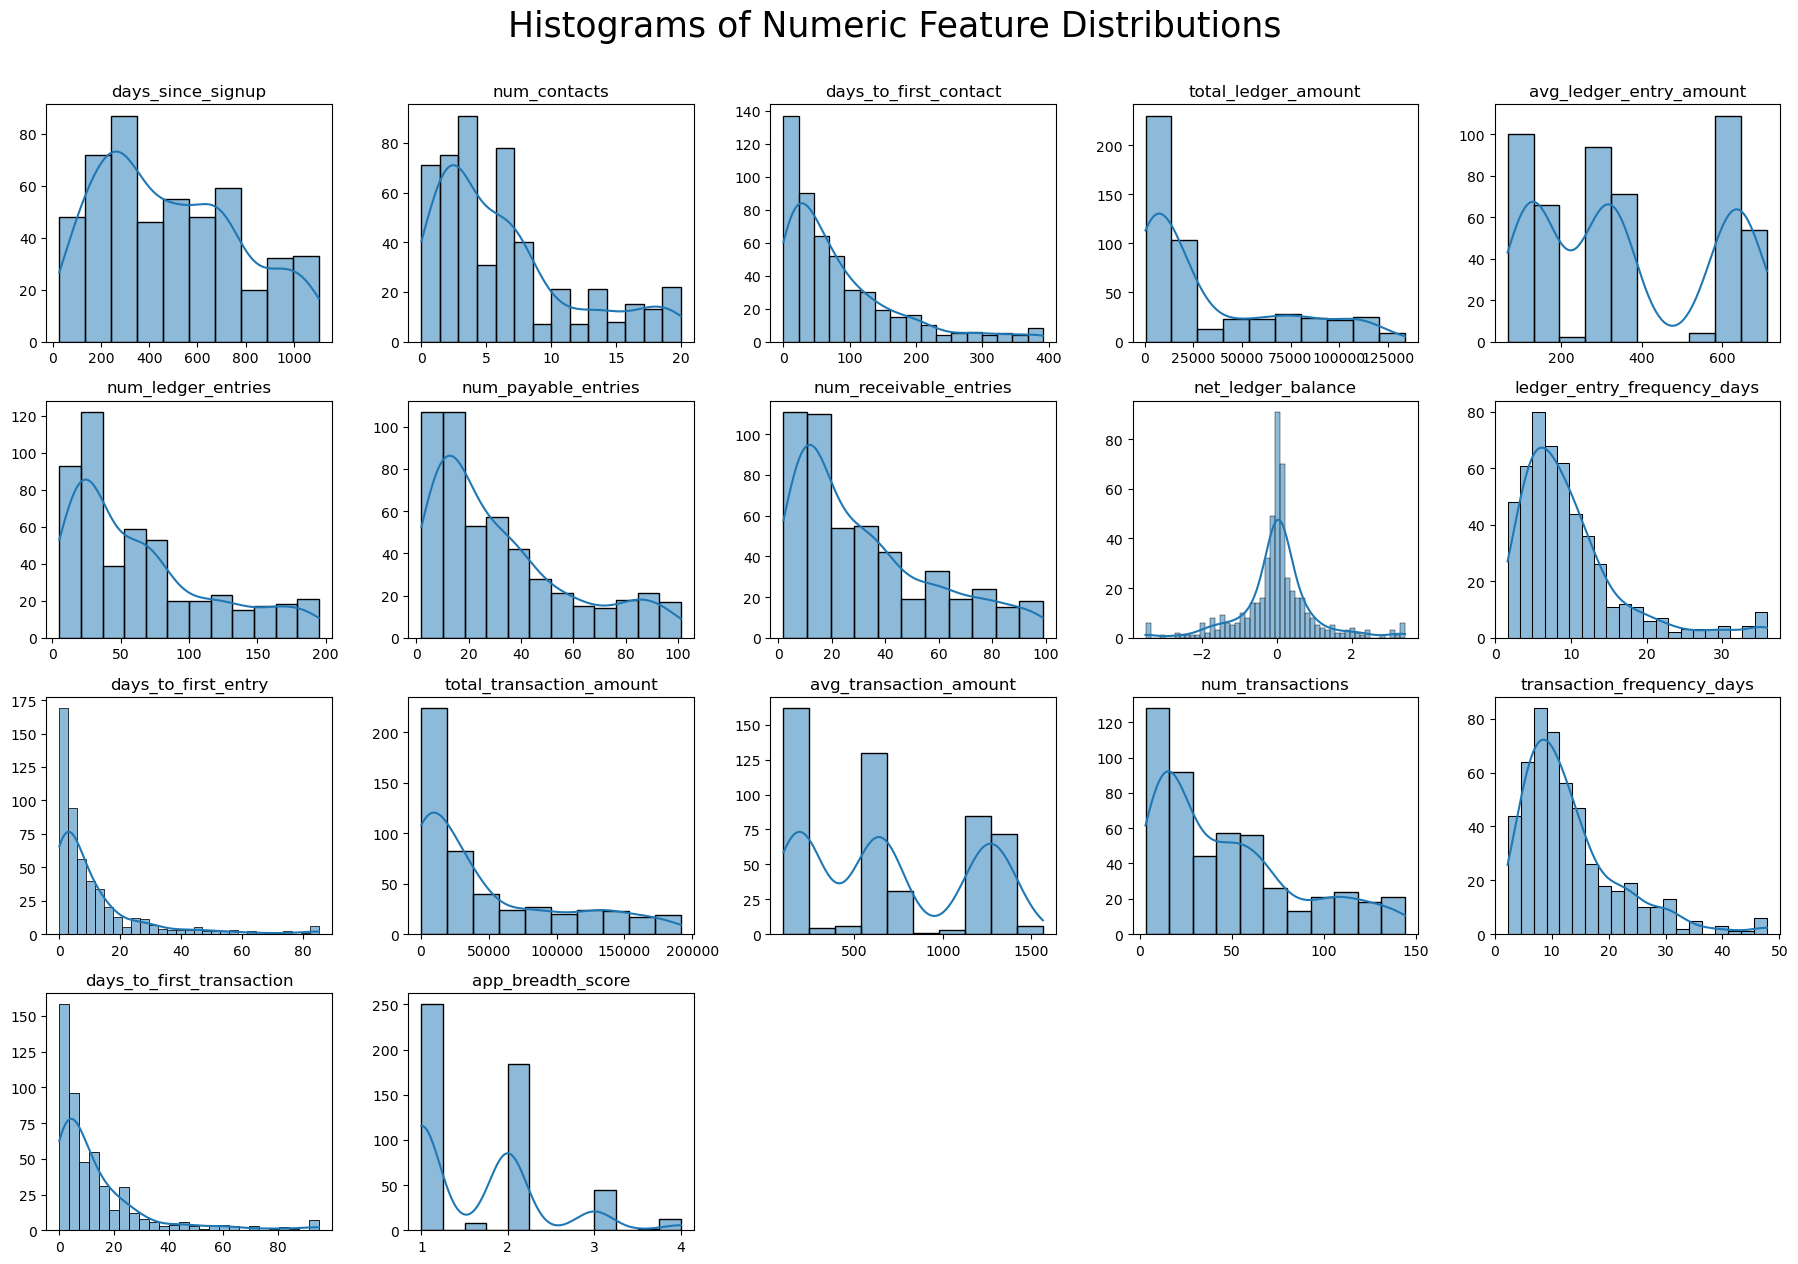


Feature Skewness Values:

days_since_signup_skewness              : 0.41
num_contacts_skewness                   : 1.07
days_to_first_contact_skewness          : 1.63
total_ledger_amount_skewness            : 1.09
avg_ledger_entry_amount_skewness        : 0.29
num_ledger_entries_skewness             : 0.97
num_payable_entries_skewness            : 1.01
num_receivable_entries_skewness         : 0.94
net_ledger_balance_skewness             : 0.06
ledger_entry_frequency_days_skewness    : 1.85
days_to_first_entry_skewness            : 2.68
total_transaction_amount_skewness       : 1.12
avg_transaction_amount_skewness         : 0.22
num_transactions_skewness               : 0.9
transaction_frequency_days_skewness     : 1.55
days_to_first_transaction_skewness      : 2.54
app_breadth_score_skewness              : 1.08


In [23]:
plt.figure(figsize=(18, 12))
for i, feature in enumerate(continuous_numerical_features):
    plt.subplot(4, 5, i + 1)
    sns.histplot(final_features_df_preprocessed[feature], kde=True)
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.suptitle('Histograms of Numeric Feature Distributions', y=1.05, fontsize=25)
plt.show()

print('\nFeature Skewness Values:\n')
for feature in continuous_numerical_features:
    skewness_value = round(skew(final_features_df_preprocessed[feature]), 2)
    print(f'{feature + "_skewness":<40}: {skewness_value}')

In [24]:
# treating features with skewed distributions

# only treating the features with "highly skewed" distributions
features_with_skewed_distributions = [feature for feature in final_features_df_preprocessed.columns 
                                      if skew(final_features_df[feature]) >= 1]

for feature in features_with_skewed_distributions:
    # shifting if there are negative values (e.g. when min value = -5, then shift by +6)
    min_value = final_features_df_preprocessed[feature].min()
    if min_value <= 0:
        shift = abs(min_value) + 1
        final_features_df_preprocessed[feature] = np.log(final_features_df_preprocessed[feature] + shift)
    else:
        final_features_df_preprocessed[feature] = np.log(final_features_df_preprocessed[feature] + 1)
    
final_features_df_preprocessed

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan,num_contacts,days_to_first_contact,total_ledger_amount,avg_ledger_entry_amount,num_ledger_entries,num_payable_entries,num_receivable_entries,net_ledger_balance,ledger_entry_frequency_days,days_to_first_entry,total_transaction_amount,avg_transaction_amount,num_transactions,transaction_frequency_days,days_to_first_transaction,app_breadth_score
0,1,32,False,False,1.098612,2.397895,7.455090,115.176000,15.0,2.197225,7.0,0.066278,0.959671,0.000000,7.746530,192.710833,12.0,1.184505,0.000000,0.693147
1,2,173,False,False,1.098612,4.219508,7.803402,128.837895,19.0,2.302585,10.0,0.119425,2.235306,2.302585,7.217443,227.000000,6.0,3.173861,3.044522,0.693147
2,3,72,False,False,0.693147,2.772589,8.102807,122.323333,27.0,2.772589,12.0,-0.100826,1.173737,0.000000,7.077464,197.326667,6.0,2.482485,0.000000,0.693147
3,4,143,True,False,1.098612,4.060443,7.247095,93.534667,15.0,2.197225,7.0,0.020253,2.216996,2.639057,7.954965,189.912667,15.0,2.313341,0.000000,0.693147
4,5,725,False,False,2.079442,3.784190,9.499343,360.809459,37.0,3.044522,17.0,-0.099587,2.950811,3.091042,10.767251,677.720286,70.0,2.413492,1.098612,0.916291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,225,False,False,1.386294,3.218876,10.110482,307.481375,80.0,3.713572,40.0,-0.143322,1.283251,1.386294,9.525662,721.368421,19.0,2.481961,1.386294,1.098612
496,497,110,True,False,0.000000,4.718499,8.107657,132.751600,25.0,2.484907,14.0,0.100021,1.605402,0.000000,6.557219,175.827500,4.0,2.450007,3.401197,0.916291
497,498,90,False,False,1.098612,4.077537,7.007148,110.350000,10.0,1.609438,6.0,0.046073,2.030754,2.772589,8.019784,202.634667,15.0,1.814725,1.609438,0.693147
498,499,706,False,False,2.079442,2.302585,9.145729,302.365161,31.0,2.639057,18.0,0.544696,3.124892,1.386294,10.619603,670.956557,61.0,2.510972,2.484907,0.693147


### Checking for High Correlations (and treating them)

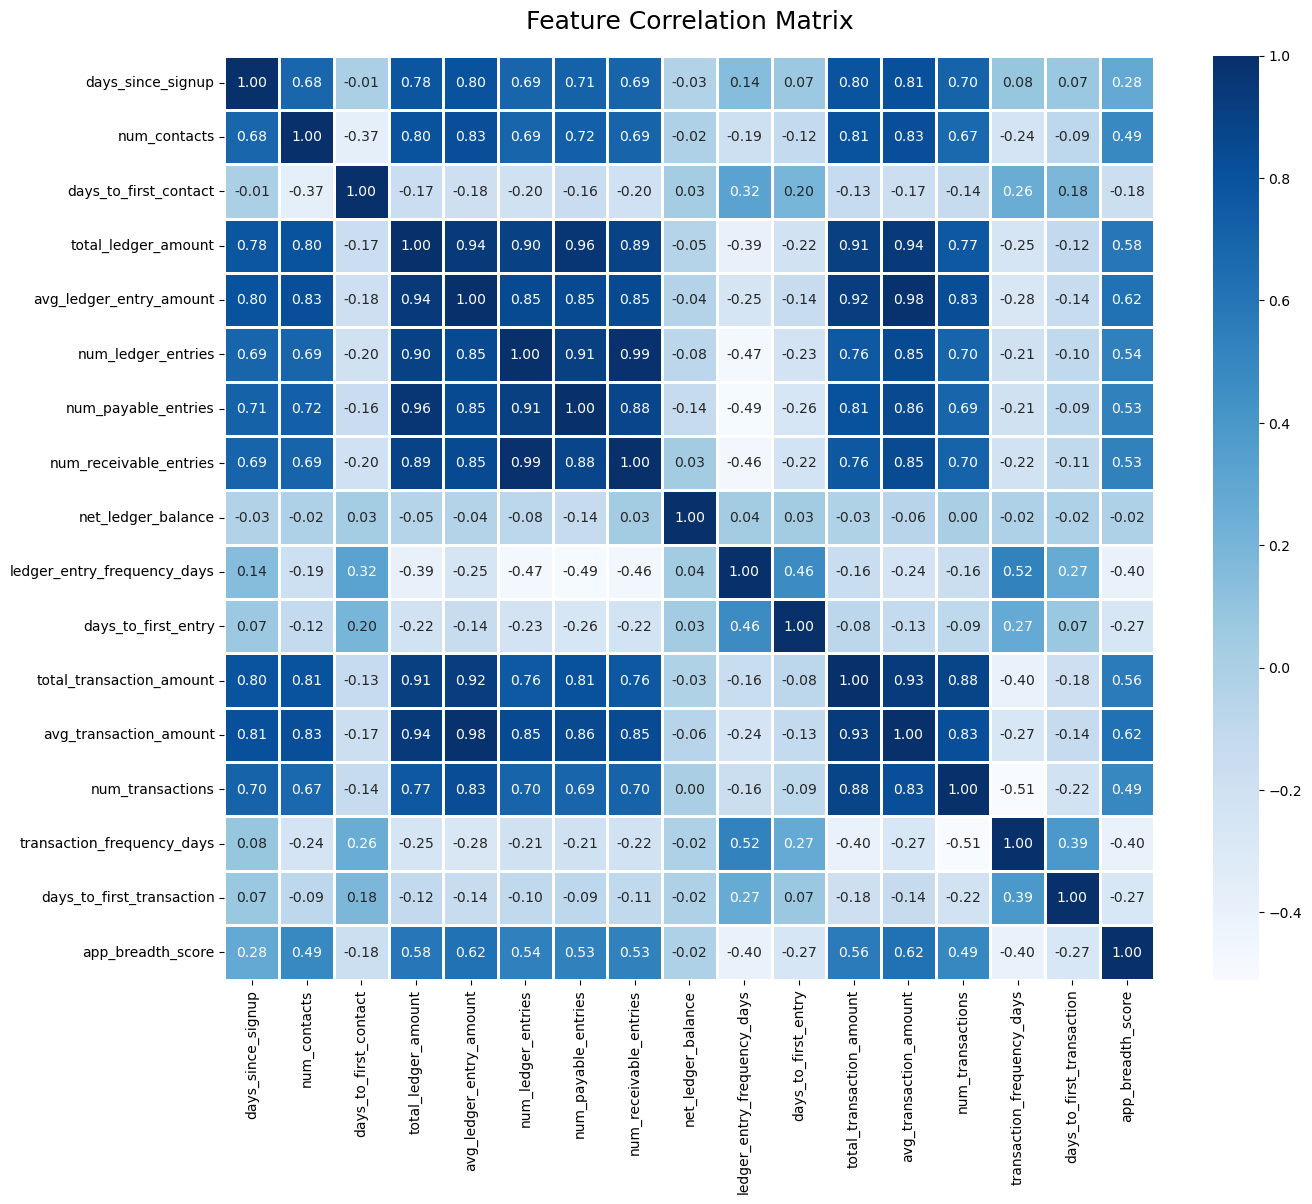

In [25]:
# checking numeric feature correlations
plt.figure(figsize=(15, 12))
correlation_matrix = final_features_df_preprocessed[numerical_features].corr() # using all numerical features including one-hot encoded ones
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=1)
plt.title('Feature Correlation Matrix', y=1.02, fontsize=18)
plt.show()

In [26]:
# removing features that are correlated in any of the pairs

upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)) # selecting upper triangle of correlation matrix

# Find features with correlation > 0.9
features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.9)]

print("Highly correlated features to drop:", features_to_drop)

final_features_df_preprocessed = final_features_df_preprocessed.drop(columns=features_to_drop)

# we drop 5 features, so out of the our initial 19, 14 features remain

Highly correlated features to drop: ['avg_ledger_entry_amount', 'num_payable_entries', 'num_receivable_entries', 'total_transaction_amount', 'avg_transaction_amount']


### Final Dataframe

In [27]:
final_features_df_preprocessed

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan,num_contacts,days_to_first_contact,total_ledger_amount,num_ledger_entries,net_ledger_balance,ledger_entry_frequency_days,days_to_first_entry,num_transactions,transaction_frequency_days,days_to_first_transaction,app_breadth_score
0,1,32,False,False,1.098612,2.397895,7.455090,15.0,0.066278,0.959671,0.000000,12.0,1.184505,0.000000,0.693147
1,2,173,False,False,1.098612,4.219508,7.803402,19.0,0.119425,2.235306,2.302585,6.0,3.173861,3.044522,0.693147
2,3,72,False,False,0.693147,2.772589,8.102807,27.0,-0.100826,1.173737,0.000000,6.0,2.482485,0.000000,0.693147
3,4,143,True,False,1.098612,4.060443,7.247095,15.0,0.020253,2.216996,2.639057,15.0,2.313341,0.000000,0.693147
4,5,725,False,False,2.079442,3.784190,9.499343,37.0,-0.099587,2.950811,3.091042,70.0,2.413492,1.098612,0.916291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,225,False,False,1.386294,3.218876,10.110482,80.0,-0.143322,1.283251,1.386294,19.0,2.481961,1.386294,1.098612
496,497,110,True,False,0.000000,4.718499,8.107657,25.0,0.100021,1.605402,0.000000,4.0,2.450007,3.401197,0.916291
497,498,90,False,False,1.098612,4.077537,7.007148,10.0,0.046073,2.030754,2.772589,15.0,1.814725,1.609438,0.693147
498,499,706,False,False,2.079442,2.302585,9.145729,31.0,0.544696,3.124892,1.386294,61.0,2.510972,2.484907,0.693147


# ==============================
# Feature Scaling
# ==============================

In [28]:
# Identifying and separating features into numeric (to be scaled) and boolean/categorical (to be one-hot encoded)

numeric_features = list(final_features_df_preprocessed.select_dtypes(include='number').drop(columns='user_id').columns)
boolean_features = list(final_features_df_preprocessed.select_dtypes(include='boolean').columns)

print(f'numeric features: \n{numeric_features}\n')
print(f'boolean features: \n{boolean_features}')


numeric features: 
['days_since_signup', 'num_contacts', 'days_to_first_contact', 'total_ledger_amount', 'num_ledger_entries', 'net_ledger_balance', 'ledger_entry_frequency_days', 'days_to_first_entry', 'num_transactions', 'transaction_frequency_days', 'days_to_first_transaction', 'app_breadth_score']

boolean features: 
['onboarded_with_referral', 'applied_for_loan']


In [29]:
# Define transformations
numeric_transformer = StandardScaler()                           # scaling numeric features to distrinution with mean 0, std 1
# other scalers for numeric field: MinMaxScaler()
boolean_transformer = FunctionTransformer(lambda x: x.astype(int))
# boolean_transformer = 'passthrough'                            # keeping boolean columns as they are (if already encoded as 0/1)
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # converting categorical variables to binary columns

# Combine into one preprocessing step
preprocessor = ColumnTransformer(                                # applying all transformations in parallel
    transformers=[                                               # list of transformers (steps)
        ('num', numeric_transformer, numeric_features),          # what the tuple values mean: (assigned_name_of_transformer, transformer, list of column names)
        ('bool', boolean_transformer, boolean_features)         
        # ('cat', categorical_transformer, categorical_features)
    ]
)


# Fit-transform the features
X = preprocessor.fit_transform(final_features_df_preprocessed)                               

# create pre-processed dataframe (for data understanding)
# Get one-hot encoded column names
# ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
# combining with numeric column names
all_feature_names = numeric_features + boolean_features # + list(ohe_feature_names)
df_transformed = pd.DataFrame(X, columns=all_feature_names)
# adding user_id back to the dataframe
df_transformed['user_id'] = final_features_df_preprocessed['user_id']
df_transformed = df_transformed[['user_id'] + all_feature_names] # bringing user_id to the front of the dataframe

df_transformed.head()

,user_id,days_since_signup,num_contacts,days_to_first_contact,total_ledger_amount,num_ledger_entries,net_ledger_balance,ledger_entry_frequency_days,days_to_first_entry,num_transactions,transaction_frequency_days,days_to_first_transaction,app_breadth_score,onboarded_with_referral,applied_for_loan
0,1,-1.573454,-0.729236,-1.131799,-1.305483,-0.953154,0.066278,-2.195520,-1.530805,-0.917708,-2.307837,-1.823897,-0.909090,0.0,0.0
1,2,-1.085656,-0.729236,0.309047,-1.080933,-0.876436,0.119425,0.053028,0.437236,-1.072612,1.203634,0.860227,-0.909090,0.0,0.0
2,3,-1.435071,-1.229601,-0.835427,-0.887912,-0.722998,-0.100826,-1.818188,-1.530805,-1.072612,-0.016735,-1.823897,-0.909090,0.0,0.0
3,4,-1.189443,-0.729236,0.183231,-1.439573,-0.953154,0.020253,0.020753,0.724822,-0.840256,-0.315296,-1.823897,-0.909090,1.0,0.0
4,5,0.824017,0.481161,-0.035278,0.012407,-0.531202,-0.099587,1.314240,1.111138,0.579697,-0.138516,-0.855334,-0.059523,0.0,0.0


# ==============================
# Running K-Means Algorithm
# ==============================

In [ ]:
# KMeans algorithm
'''
- KMeans() function partitions your data into k distinct, non-overlapping groups (clusters) based on feature similarity.
- Each cluster is defined by a centroid (the mean of the points in that cluster). 
- The algorithm iteratively adjusts these centroids and reassigns points to the nearest centroid until the cluster 
assignments stabilize
- If you start with bad centroids, K-Means can get stuck in a bad solution.
'''

### Silhouette Scores Method

In [ ]:
# Silhouette Scores
'''
- Silhouette scores are a metric used to evaluate the quality of clustering
- They measure how similar each point is to its own cluster (cohesion) compared to other clusters (separation)

| Silhouette Score (s) | Interpretation                       |
| -------------------- | ------------------------------------ |
| +1                   | Very well-clustered                  |
| ~0                   | On the border between clusters       |
| -1                   | Misclassified / in the wrong cluster |

=> We use it to evaluate the optimal number of clusters (k) in K-means.
'''

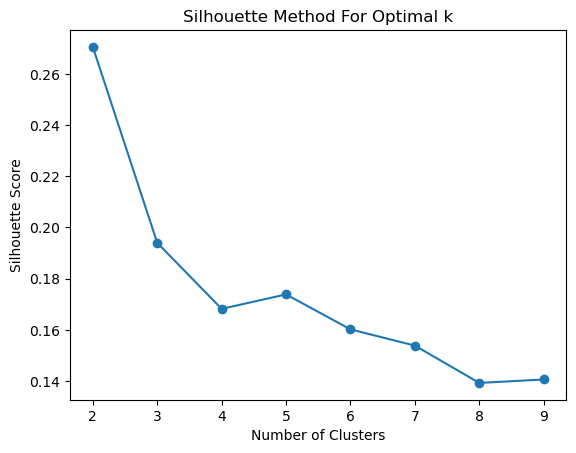

Optimal number of clusters: 2


In [32]:
# Silhouette Scores Method (to determine optimal number of clusters)

silhouette_scores = []
K = range(2, 10)                                               # running K-means for different values of k (2 to 9)

for k in K:
    # creating an instance of the KMeans clustering algorithm
    # note: this function does not apply KMeans to any data yet, it just creates the model object
    kmeans = KMeans(
        n_clusters=k, # Number of clusters (k) to form
        random_state=42, # Set a seed for reproducibility
        n_init=10 # Runs the whole K-Means algorithm 10 times with different initial centroids, and returns the one with the lowest error (sum of squared distances from each point to its assigned cluster centroid)
    )
    # kmeans.fit(X) learns the clusters from the data X
    # kmeans.predict(X) assigns a cluster label to each point in X.
    # kmeans.fit_predict(X) learns the clusters AND assigns a cluster label to each point in X, both in one single step
    labels = kmeans.fit_predict(X) # It clusters your data by (1) Learning the clusters from your data (fit) and (2) Assigning each data point to the nearest cluster (predict). It returns a list of cluster labels (like 0, 1, 2...) for each row in X
    silhouette_scores.append(silhouette_score(X, labels))    

# plotting silhouette Scores (to help visually pick the best K)
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method For Optimal k")
plt.show()

# selecting optimal k
optimal_k_silhouette = K[np.argmax(silhouette_scores)]         # saving the optimal number of clusters (index of the max value in the list of silhouette_scores)
print("Optimal number of clusters:", optimal_k_silhouette)


### Elbow Method

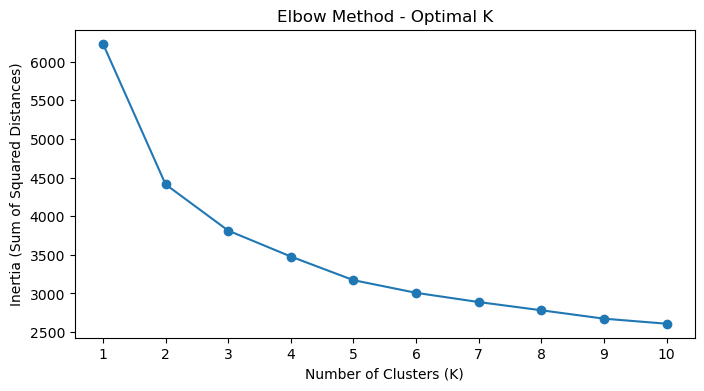

In [33]:
# Elbow Method (to determine optimal number of clusters)
'''
- It’s a way to plot the inertia (clustering error) for different values of K (number of clusters), 
and find the point where the improvement slows down, which we call the "elbow"
- clustering error = sum of squared distances from each point to its assigned cluster centroid
- How to interpret the plot:
    - look for the point where inertia drops sharply, then levels off
    - that "elbow" point is our ideal K
'''

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit_predict(X) 
    inertia.append(kmeans.inertia_)

# Plotting the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method - Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(K_range)
plt.show()


# based on the chart below, it seems that after K=3, the clustering error starts to level off 
optimal_k_elbow = 3


In [85]:
# creating the clusters -- silhouette score method

kmeans_silhouette = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init=10)
cluster_labels_silhouette = kmeans_silhouette.fit_predict(X)

# Assign cluster to original dataframe
final_features_df.loc[:, 'cluster_silhouette'] = cluster_labels_silhouette


In [86]:
# creating the clusters -- elbow method

kmeans_elbow = KMeans(n_clusters=optimal_k_elbow, random_state=42, n_init=10)
cluster_labels_elbow = kmeans_elbow.fit_predict(X)

# Assign cluster to original dataframe
final_features_df.loc[:, 'cluster_elbow'] = cluster_labels_elbow

In [48]:
final_features_df

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan,num_contacts,days_to_first_contact,total_ledger_amount,avg_ledger_entry_amount,num_ledger_entries,num_payable_entries,...,total_transaction_amount,avg_transaction_amount,num_transactions,transaction_frequency_days,days_to_first_transaction,app_breadth_score,cluster_silhouette,cluster_elbow,pca_1,pca_2
0,1,32,False,False,2.0,10.0,1727.64,115.176000,15,8,...,2312.53,192.710833,12,1.220518,0,1.0,0,2,-0.871056,-4.566173
1,2,173,False,False,2.0,67.0,2447.92,128.837895,19,9,...,1362.00,227.000000,6,22.899583,20,1.0,0,1,-2.684272,0.152089
2,3,72,False,False,1.0,15.0,3302.73,122.323333,27,15,...,1183.96,197.326667,6,10.970972,0,1.0,0,2,-1.414423,-3.295900
3,4,143,True,False,2.0,57.0,1403.02,93.534667,15,8,...,2848.69,189.912667,15,9.108135,0,1.0,0,2,-2.068359,-1.326978
4,5,725,False,False,7.0,43.0,13349.95,360.809459,37,20,...,47440.42,677.720286,70,10.172907,2,1.5,0,1,0.047630,1.073543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,225,False,False,3.0,24.0,24598.51,307.481375,80,40,...,13706.00,721.368421,19,10.964699,3,2.0,0,2,0.249609,-1.822958
496,497,110,True,False,0.0,111.0,3318.79,132.751600,25,11,...,703.31,175.827500,4,10.588426,29,1.5,0,2,-2.081146,-1.712948
497,498,90,False,False,2.0,58.0,1103.50,110.350000,10,4,...,3039.52,202.634667,15,5.139385,4,1.0,0,2,-2.274067,-1.527939
498,499,706,False,False,7.0,9.0,9373.32,302.365161,31,13,...,40928.35,670.956557,61,11.316898,11,1.0,0,1,-0.358879,0.895127


# ==============================
# Visualizing the Clusters
# ==============================

In [50]:
final_features_df

,user_id,days_since_signup,onboarded_with_referral,applied_for_loan,num_contacts,days_to_first_contact,total_ledger_amount,avg_ledger_entry_amount,num_ledger_entries,num_payable_entries,...,total_transaction_amount,avg_transaction_amount,num_transactions,transaction_frequency_days,days_to_first_transaction,app_breadth_score,cluster_silhouette,cluster_elbow,pca_1,pca_2
0,1,32,False,False,2.0,10.0,1727.64,115.176000,15,8,...,2312.53,192.710833,12,1.220518,0,1.0,0,2,-0.871056,-4.566173
1,2,173,False,False,2.0,67.0,2447.92,128.837895,19,9,...,1362.00,227.000000,6,22.899583,20,1.0,0,1,-2.684272,0.152089
2,3,72,False,False,1.0,15.0,3302.73,122.323333,27,15,...,1183.96,197.326667,6,10.970972,0,1.0,0,2,-1.414423,-3.295900
3,4,143,True,False,2.0,57.0,1403.02,93.534667,15,8,...,2848.69,189.912667,15,9.108135,0,1.0,0,2,-2.068359,-1.326978
4,5,725,False,False,7.0,43.0,13349.95,360.809459,37,20,...,47440.42,677.720286,70,10.172907,2,1.5,0,1,0.047630,1.073543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,225,False,False,3.0,24.0,24598.51,307.481375,80,40,...,13706.00,721.368421,19,10.964699,3,2.0,0,2,0.249609,-1.822958
496,497,110,True,False,0.0,111.0,3318.79,132.751600,25,11,...,703.31,175.827500,4,10.588426,29,1.5,0,2,-2.081146,-1.712948
497,498,90,False,False,2.0,58.0,1103.50,110.350000,10,4,...,3039.52,202.634667,15,5.139385,4,1.0,0,2,-2.274067,-1.527939
498,499,706,False,False,7.0,9.0,9373.32,302.365161,31,13,...,40928.35,670.956557,61,11.316898,11,1.0,0,1,-0.358879,0.895127


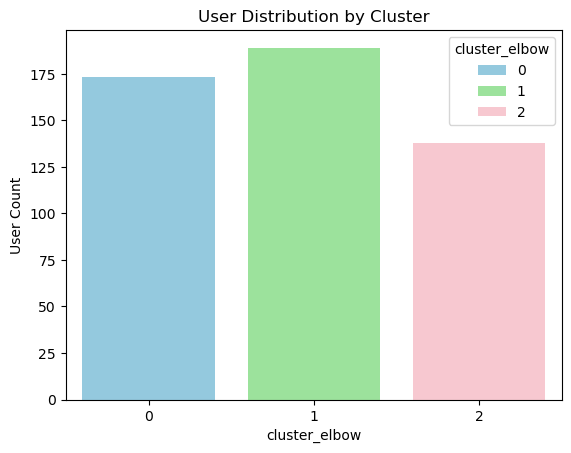

In [82]:
# count of customers in each cluster

sns.barplot(
    data=final_features_df.groupby('cluster_elbow').agg(user_count=('user_id', 'count')).reset_index(), 
    x='cluster_elbow', 
    y='user_count',
    hue='cluster_elbow',
    palette={0:'skyblue', 1:'lightgreen', 2:'pink'}
)
plt.title('User Distribution by Cluster')
plt.ylabel('User Count')
plt.show()

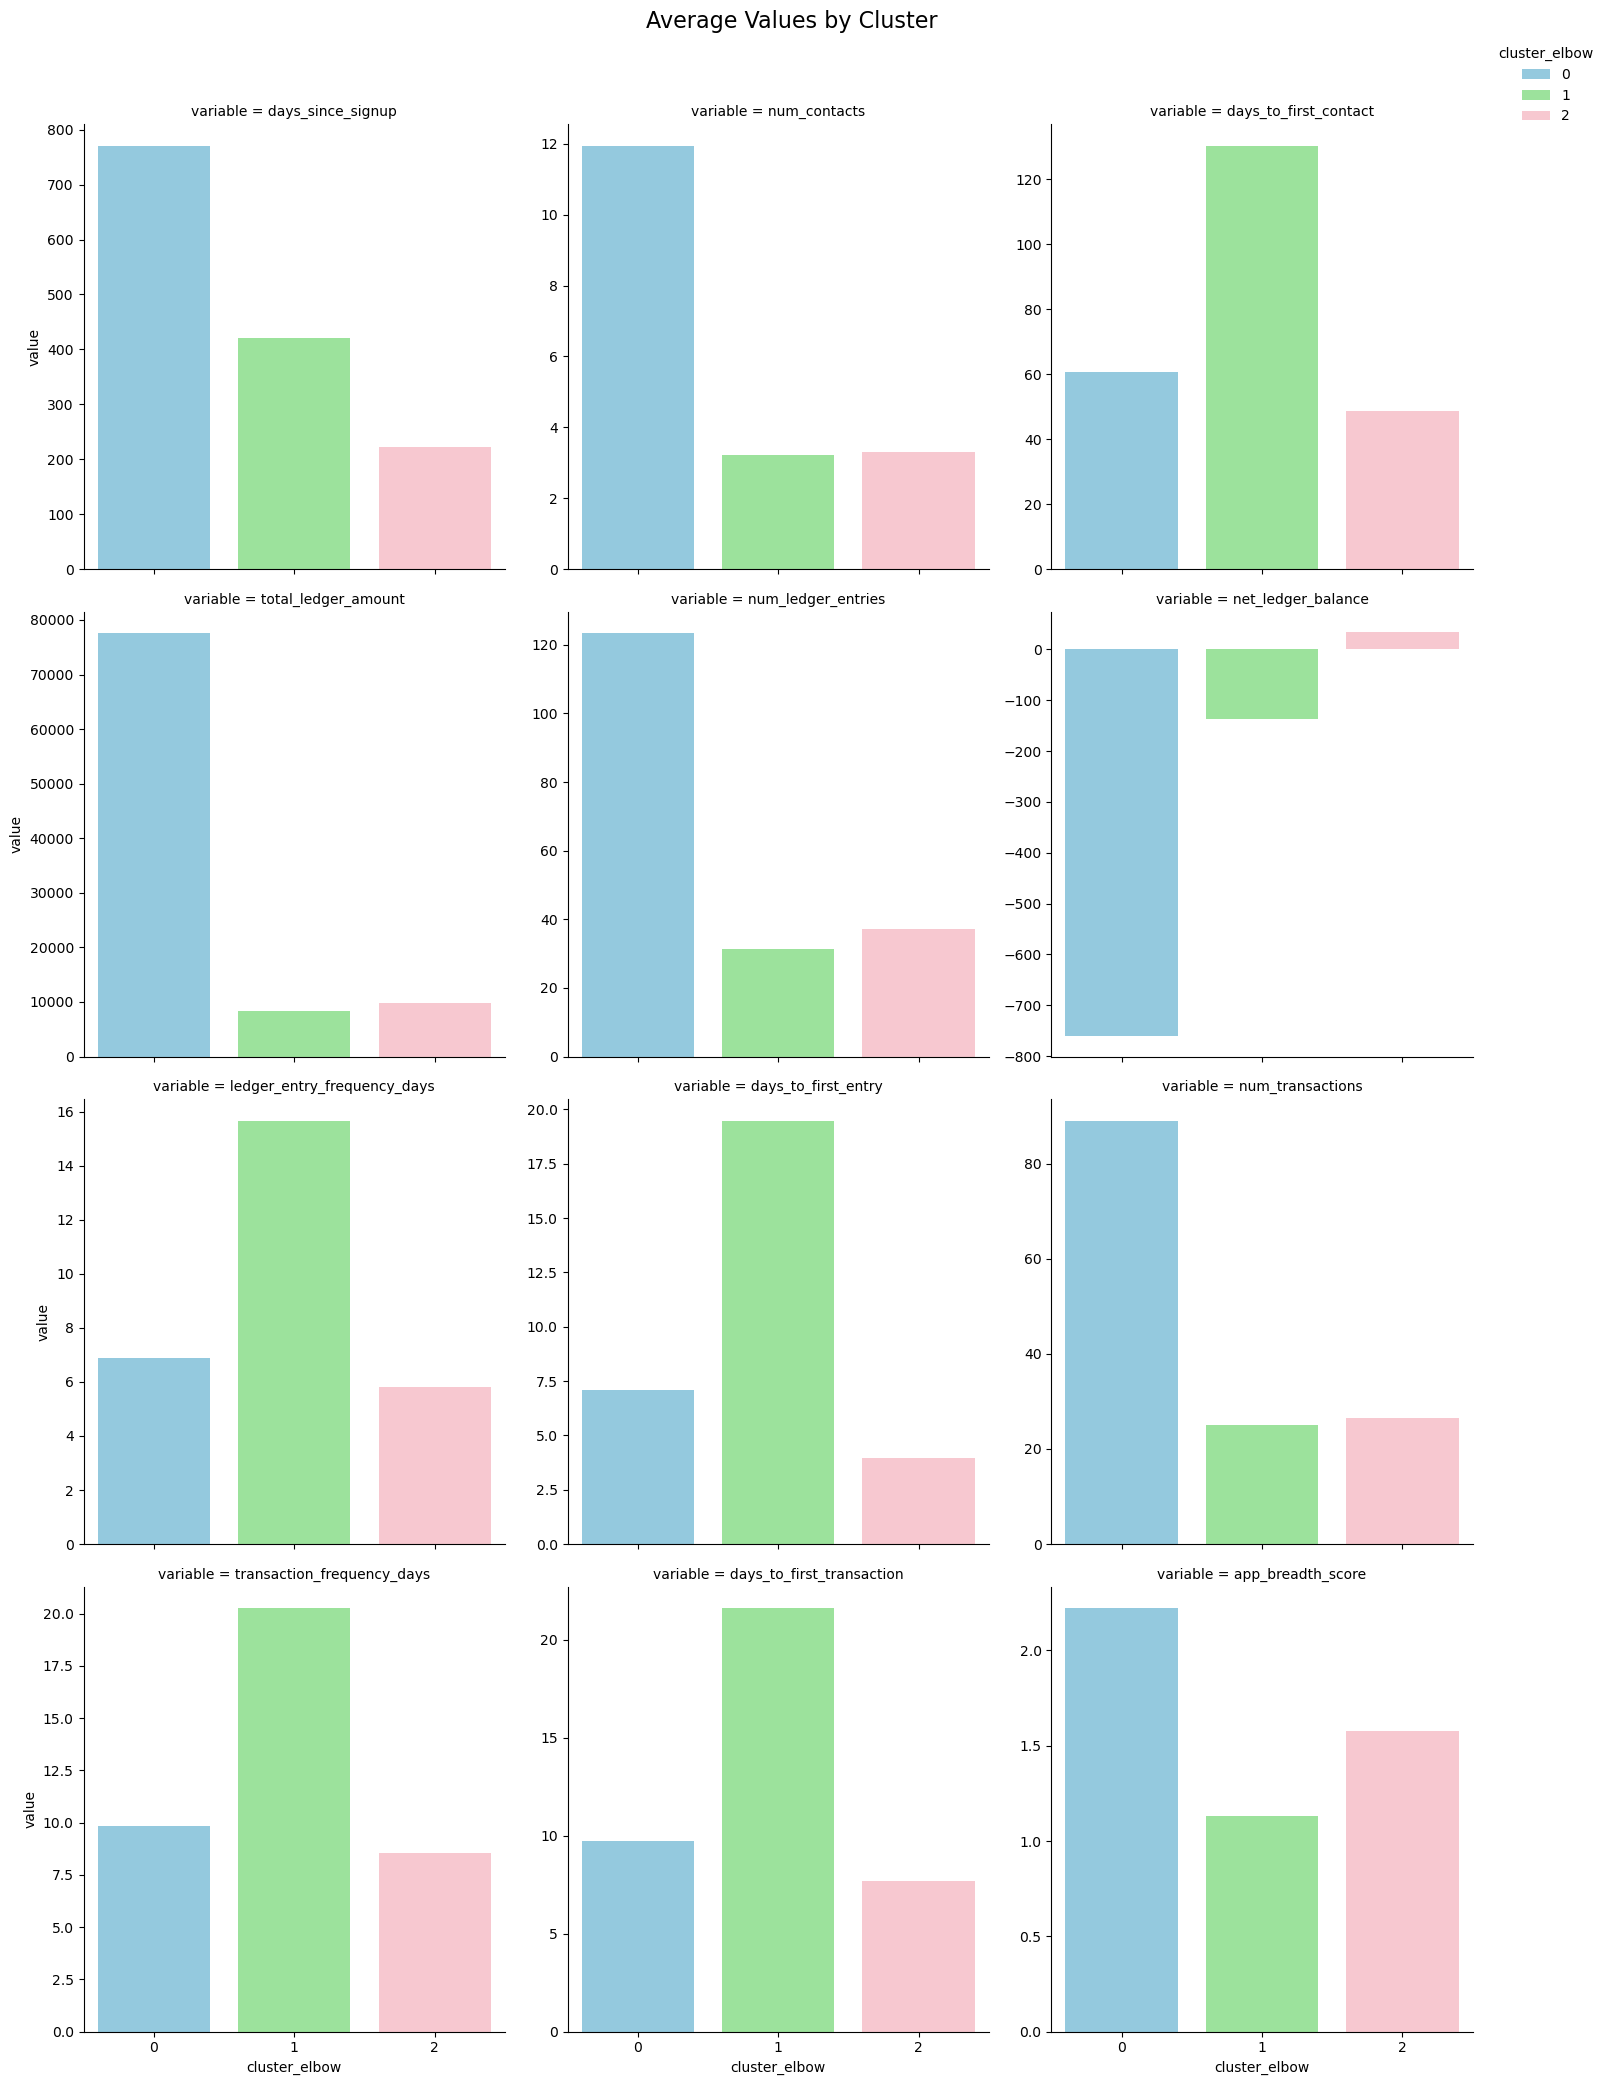

In [56]:
# calculating the mean of feature columns by cluster
df_means = (
    final_features_df
    .groupby(['cluster_elbow'])
    [numeric_features]
    .mean()
    .reset_index()
)

# plotting the distributions of the numeric features
c = sns.catplot(
    data=df_means.melt(id_vars='cluster_elbow'),  
    col='variable',
    x='cluster_elbow',
    y='value',
    kind='bar',
    hue='cluster_elbow',
    palette={0:'skyblue', 1:'lightgreen', 2:'pink'},
    col_wrap=3,
    height=5,
    aspect=1,
    sharey=False,
)
c._legend.set_bbox_to_anchor((1, 1))
plt.suptitle('Average Values by Cluster', y=1.04, fontsize=16)
plt.show()

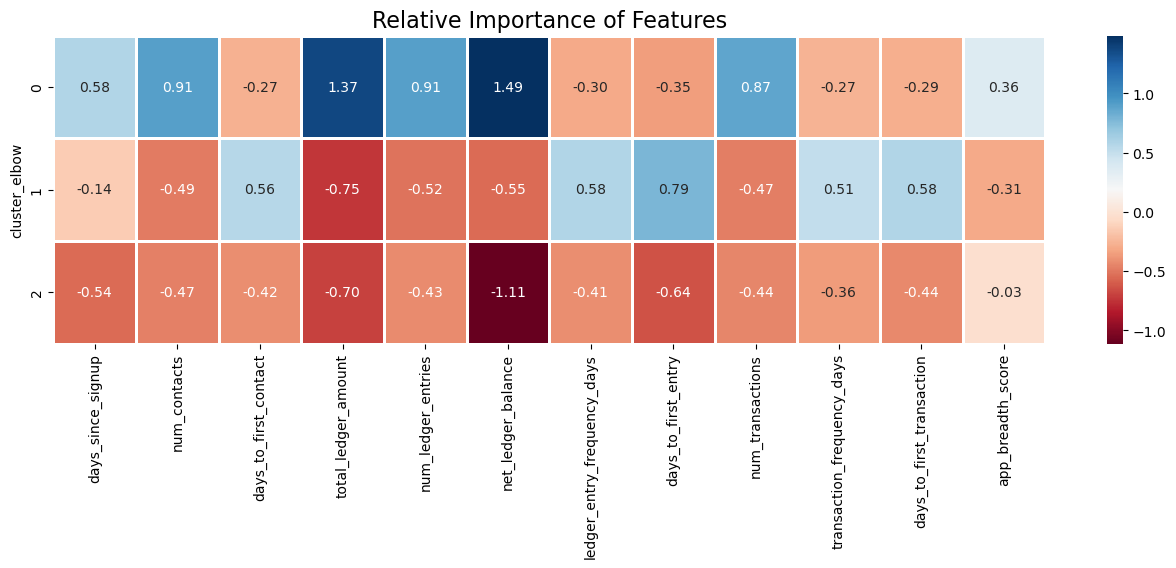

In [81]:
# relative importance of features

# calculating average feature values for each cluster
cluster_avg = final_features_df.groupby(['cluster_elbow'])[numeric_features].mean()

# calculating average feature values for the total user population
population_avg = final_features_df[numeric_features].mean()

# calculating relative importance of cluster's feature value compared to population
relative_imp = cluster_avg / population_avg - 1

# plotting the heatmap
plt.figure(figsize=(16, 4))
sns.heatmap(relative_imp, annot=True, cmap='RdBu', fmt='2f', linewidths=1)
plt.title('Relative Importance of Features', fontsize=16)
plt.show()